In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from utils import general as gen

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, plot_roc_curve, 
    recall_score, precision_score, 
    accuracy_score, confusion_matrix
)
from sklearn.externals import joblib

import mlflow

/home/jpcano1/Documents/Universidad/Analysis with ML/Workshops/Lab Despliegue/ml_flow/venv/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
data_id = "1FmgtiLqKpUE_glH7aSXpMDnjsuUWe_9Y"

In [7]:
gen.download_file_from_google_drive(data_id, "spam.csv", size=504)

  0%|          | 0/504 [00:00<?, ?KB/s]

In [8]:
data = pd.read_csv("data/spam.csv", encoding="latin-1")

In [9]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [11]:
data.rename(columns={'v1':'label',
                     'v2':'message'}, inplace = True)

In [12]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
data["label"] = data["label"].apply(lambda x: 0 if x == "ham" else 1)

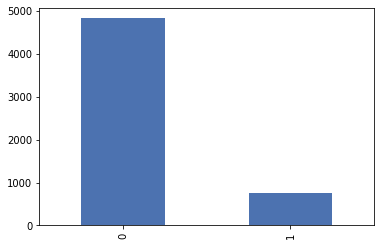

In [14]:
data['label'].value_counts().plot(kind='bar')
plt.show()

In [15]:
label = data["label"]
text_data = data["message"]

In [16]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(analyzer="word")),
    ("transformer", TfidfTransformer(use_idf=False))
])

In [17]:
text_data = pipeline.fit_transform(text_data)

In [18]:
text_data = pd.DataFrame(text_data.toarray(), 
                         columns=pipeline.steps[0][1].get_feature_names())

In [19]:
text_data.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X = text_data.values
y = label.values

In [21]:
splitter = StratifiedShuffleSplit(random_state=1234, test_size=0.2)

In [22]:
for full_train_index, test_index in splitter.split(X, y):
    pass

full_X_train, full_y_train = X[full_train_index], y[full_train_index]
X_test, y_test = X[test_index], y[test_index]

In [23]:
for train_index, val_index in splitter.split(full_X_train, full_y_train):
    pass

X_train, y_train = full_X_train[train_index], full_y_train[train_index]
X_val, y_val = full_X_train[val_index], full_y_train[val_index]

In [24]:
def train(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)

    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [25]:
def evaluate(sk_model, X_test, y_test):
    eval_acc = sk_model.score(X_test, y_test)

    y_pred = sk_model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred)
    eval_recall = recall_score(y_test, y_pred)
    eval_precision = precision_score(y_test, y_pred)

    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)

    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    print(f"Eval Recall: {eval_recall: .3%}")
    print(f"Eval Precision: {eval_precision: .3%}")

    roc_plot = plot_roc_curve(
        sk_model, X_test, 
        y_test, name="Scikit-Learn ROC Curve"
    )
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="g")
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

In [26]:
log_reg = LogisticRegression(
    random_state=1234, max_iter=400, solver="newton-cg"
)

INFO: 'Scikit Learn Experiment' does not exist. Creating a new experiment
Train Accuracy: 97.363%
Auc Score: 87.093%
Eval Accuracy: 96.323%
Eval Recall:  74.497%
Eval Precision:  97.368%


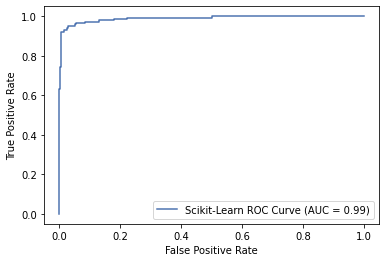

Model Run:  e61cd17e215a441d964f8bf22c299dcc


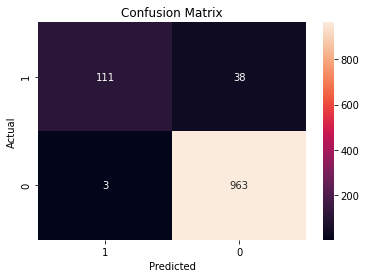

In [27]:
mlflow.set_experiment("Scikit Learn Experiment")
with mlflow.start_run():
    train(log_reg, X_train, y_train)
    evaluate(log_reg, X_test, y_test)
    mlflow.sklearn.log_model(log_reg, "Log Reg Model")
    print("Model Run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()